# Installing acspype

acspype can be install using pip.

`pip install acspype`

or if you are installing via a Jupyter cell

`!pip install acspype`

## Import Required Packages for this Example

In [1]:
import gsw
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
import xarray as xr

from acspype.utils.ooi import download_and_load_goldcopy, reformat_ooi_optaa, get_ooi_optaa_cal
import acspype.processing as acsproc
import acspype.qaqc as acsqaqc
from acspype.tscor import ACSTSCor

# OOI CE02SHSP Example


In this example, we will be using ACS data from the [OOI Oregon Shelf Coastal Surface Piercing Profiler (CE02SHSP)](https://thredds.dataexplorer.oceanobservatories.org/thredds/catalog/ooigoldcopy/public/CE02SHSM-RID27-01-OPTAAD000-recovered_host-optaa_dj_dcl_instrument_recovered/catalog.html). 

This data contains profiles of ACS data from roughly 75m depth to the sea-surface. The data used in this example in particular are from a deployment where the profiler failed to follow its prescribed sampling regime and instead collected a profile every 20 minutes for 3 days before its batteries died.

The data made available from OOI already has the nearest neighbor salinity, temperature, and pressure assigned to each ACS timestamp. One thing to consider is that the ACS data from the OOI are not time-lag corrected. This example does not handle any time-lag correction or does not consider the depth difference between sensors, which is something that should be done if performing analyses that require small depth bins (sub-meter).

#### Download and Select OOI Data
If you inspect the data before it is reformatted, you'll find that it has the dimensions of `obs` and `wavelength`. These two dimensions are not compatible with *acspype* and do not provide any meaningful information that can't already be determined by inspecting the shape of the data. `obs` is simply an iterative identifier for a file and does not express the uniqueness of the sample (a better use would be the UUID). `wavelength`, in this instance, is also an iterative identifier and not actually representative of the actual wavelength, but rather the index of the wavelength bin. This is particularly confusing because variables associated with absorption will have different wavelengths compared to those associated with attenuation. ACS data is much better represented by the dimensions of `a_wavelength` and `c_wavelength`, which are unique and attached to specific absorption and attenuation variables. Later in this example we will show how to linearly interpolate between wavelengths to obtain common bins, which makes it easier to perform scattering correction on ACS data.

Since all OOI ACS assets are (currently) immobile and files ***SHOULD*** only contain data from one ACS, the reformatted dataset reassigns latitude, longitude, and deployment as coordinates rather than variables. If continuing to use Xarray, the acspype functions should handle these extra dimensions, but this example will whittle the dataset down to the coordinates of `time`, `a_wavelength`, and `c_wavelength` for simplicity.

In [2]:
acs_url = 'https://thredds.dataexplorer.oceanobservatories.org/thredds/fileServer/ooigoldcopy/public/CE02SHSP-SP001-04-OPTAAJ000-recovered_cspp-optaa_dj_cspp_instrument_recovered/deployment0013_CE02SHSP-SP001-04-OPTAAJ000-recovered_cspp-optaa_dj_cspp_instrument_recovered_20190624T165543.774000-20190627T023924.583000.nc'
acs = download_and_load_goldcopy(thredds_fileserver_url=acs_url,
                                 save_dir = 'ooi_data/')

In [3]:
acs  # ACS data before reformatting

<xarray.Dataset> Size: 393MB
Dimensions:                       (obs: 131979, wavelength: 86)
Coordinates:
  * obs                           (obs) int32 528kB 0 1 2 ... 131977 131978
    lat                           (obs) float64 1MB ...
  * wavelength                    (wavelength) int32 344B 0 1 2 3 ... 83 84 85
    lon                           (obs) float64 1MB ...
    depth                         (obs) float64 1MB ...
    time                          (obs) datetime64[ns] 1MB ...
Data variables: (12/30)
    external_temp_raw             (obs) float32 528kB ...
    c_signal_counts               (obs, wavelength) float32 45MB ...
    deployment                    (obs) int32 528kB ...
    a_signal_counts               (obs, wavelength) float32 45MB ...
    int_ctd_pressure              (obs) float64 1MB ...
    a_reference_counts            (obs, wavelength) float32 45MB ...
    ...                            ...
    preferred_timestamp           (obs) object 1MB ...
    a_signal_dark_counts          (obs) float32 528kB ...
    c_reference_counts            (obs, wavelength) float32 45MB ...
    a_reference_dark_counts       (obs) float32 528kB ...
    suspect_timestamp             (obs) float32 528kB ...
    sea_water_temperature         (obs) float64 1MB ...
Attributes: (12/68)
    node:                               SP001
    comment:                            
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_cspp
    stream:                             optaa_dj_cspp_instrument_recovered
    ...                                 ...
    geospatial_lon_max:                 -123.69743
    geospatial_lon_units:               degrees_east
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down

The `reformat_ooi_optaa` function removes the OOI-processed beam attenuation and optical absorption. These variables do not consider discontinuity or zero shift correction. In this example, we will recalculate these variables from the raw data, so they are removed in the cell below.

In [4]:
acs = reformat_ooi_optaa(ds = acs)
acs = acs.sel(latitude = float(acs.latitude), longitude = float(acs.longitude), deployment = int(acs.deployment))

In [5]:
acs  # ACS data after reformatting

<xarray.Dataset> Size: 191MB
Dimensions:                       (time: 131979, a_wavelength: 86,
                                   c_wavelength: 86)
Coordinates:
    latitude                      float64 8B 44.63
    longitude                     float64 8B -123.7
    deployment                    int32 4B 13
    depth                         (time) float64 1MB ...
  * time                          (time) datetime64[ns] 1MB 2019-06-24T16:55:...
  * a_wavelength                  (a_wavelength) float64 688B 401.2 ... 746.8
  * c_wavelength                  (c_wavelength) float64 688B 399.4 ... 749.7
Data variables: (12/14)
    a_reference                   (time, a_wavelength) float32 45MB 604.0 ......
    a_reference_dark              (time) float32 528kB 473.0 473.0 ... 471.0
    a_signal                      (time, a_wavelength) float32 45MB 462.0 ......
    a_signal_dark                 (time) float32 528kB 709.0 709.0 ... 712.0
    c_reference                   (time, c_wavelength) float32 45MB 614.0 ......
    c_reference_dark              (time) float32 528kB 476.0 476.0 ... 475.0
    ...                            ...
    elapsed_time                  (time) float32 528kB 5.041e+04 ... 2.107e+05
    raw_external_temperature      (time) float32 528kB 4.116e+04 ... 3.889e+04
    raw_internal_temperature      (time) float32 528kB 5.149e+04 ... 5.079e+04
    sea_water_practical_salinity  (time) float64 1MB 33.98 34.01 ... 31.18 31.18
    sea_water_pressure            (time) float64 1MB 77.44 77.44 ... 0.742
    sea_water_temperature         (time) float64 1MB 7.288 7.288 ... 15.22 15.21
Attributes: (12/59)
    AssetManagementRecordLastModified:  2023-06-02T18:55:55.111000
    AssetUniqueID:                      CGINS-OPTAAJ-00138
    Conventions:                        CF-1.6
    Description:                        Spectrophotometer: OPTAA Series J
    FirmwareVersion:                    Not specified.
    Manufacturer:                       WET Labs
    ...                                 ...
    time_coverage_end:                  2019-06-27T02:39:24.583000
    time_coverage_resolution:           P1.57S
    time_coverage_start:                2019-06-24T16:55:43.774000
    title:                              Data produced by Stream Engine versio...
    uuid:                               62529081-0c5a-42f1-a139-b717249fdf1e
    number_of_output_wavelengths:       86

#### Download OOI Device Calibration Information
Normally, you would use the `ACSDev` class to import device calibration information from the ACS device file (ACS-XXX.dev). However, the OOI does not make these terribly accessible, but they do provide the coefficients in JSON form through their REST API. The `get_ooi_optaa_cal` function will download the device file infor from the OOI REST API and return an `ACSDev` compatible object with the calibration information.

In [6]:
acs_dev = get_ooi_optaa_cal(ds = acs) # The get_ooi_optaa_cal function uses the uid in the dataset attributes.

#### Quick Verification of Data and Device File
The device file is a file that is unique to each ACS. For OOI datasets, one way to verify that you have the correct device file information is to verify that the wavelength values match between the file and the calibration information. In some rare cases, two calibration files for the same instrument may have the same wavelengths, so it is important to use the calibration information that happens before the data collection and is closest to the first timestamp in the dataset. The `get_ooi_optaa_cal` function does this automatically. There are more complex ways to compare the device file to the sensor output, but for this example, comparing the wavelengths is sufficient.

In [7]:
assert np.all(acs_dev.a_wavelength == acs.a_wavelength)  # Will raise an error if the wavelengths do not match.

## Reprocess Data

The processing steps in the cells below follow most of the steps outline in the [Recommended Processing Steps (1.0 - 4.1)](https://github.com/IanTBlack/acspype/blob/main/info/PROCESSING.md) in the *acspype* documentation. There are several key things to note about OOI data.

This examples skips the following steps:
- Step 1.5: Application of User-Collected Pure Water Coefficients. These are sometimes performed by the OOI, but are not easily accessible and require formatting to work with *acspype*. For the sake of brevity, this step is skipped.
- Step 1.7: Time-lag Correction is not performed. The CTD is located roughly 30cm below the intake of the ACS. However, the ACS intake to the flow cell distance is roughly 50 cm and water is pulled through using a SBS 5T pump. For this example, we just assume everything is contemporary and co-located at the same depth.
- Step 2.0: Lag correction between the absorption and attenuation channels is not necessary for the ACS on this profiler because the flow cells are plumbed in parallel.
- Step 5.0: Splitting of data into particulate and gelbstoff datasets. This is not done because the OOI does not filter ACS water to obtain the gelbstoff signal.


### Step 1.1: Compute Internal and External Temperature from Raw Counts

In [8]:
acs['internal_temperature'] = acsproc.compute_internal_temperature(counts = acs.raw_internal_temperature)
acs['external_temperature'] = acsproc.compute_external_temperature(counts = acs.raw_external_temperature)

### Step 1.2: Optionally Compute Sea Water Absolute Salinity and Sea Water Conservative Temperature

In [9]:
acs['sea_water_absolute_salinity'] = gsw.SA_from_SP(acs.sea_water_practical_salinity, acs.sea_water_pressure, acs.longitude, acs.latitude)
acs['sea_water_conservative_temperature'] = gsw.CT_from_t(acs.sea_water_absolute_salinity, acs.sea_water_temperature, acs.sea_water_pressure)

### Step 1.3: Compute Uncorrected Absorption and Attenuation

In this next cell, uncorrected absorption and attenuation are computed. At this stage, the data are converted from raw counts to geophysical units (m^-1). However, this data has not yet been corrected for internal temperature of the instrument and its impact on values as well as corrected for the effect of pure water. 

You will likely observe that a RuntimeWarning occurs that describes a divide by zero scenario in a log. This is expected behaviour for the function and indicates that there are reference values that are equal to zero. Division by zero leads to NaNs. Leaving these NaNs in the dataset is will propagate them throughout the rest of the calculations. They can be removed now or later. Consecutive NaNs likely indicate an issue with the sensor (e.g. lamp is dead). The occasional spectrum with a NaN may occur and can be likely be removed without signicant loss of data for analysis. In the QAQC steps below, you will see that a few  hundred a and c samples contain NaNs in the spectra, which is not a significant portion of the 1.3 million samples in this dataset.

In [10]:
acs['a_uncorrected'] = acsproc.compute_uncorrected(signal_counts=acs.a_signal, 
                                                   reference_counts = acs.a_reference, 
                                                   path_length=acs_dev.path_length)

acs['c_uncorrected'] = acsproc.compute_uncorrected(signal_counts=acs.c_signal, 
                                                   reference_counts=acs.c_reference, 
                                                   path_length =acs_dev.path_length)

C:\Users\Ian\phd\projects\acspype\.venv\Lib\site-packages\xarray\computation\apply_ufunc.py:818: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
C:\Users\Ian\phd\projects\acspype\.venv\Lib\site-packages\xarray\computation\apply_ufunc.py:818: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


### Step 1.4: Compute Measured Absorption and Attenuation

The measured absorption and attenuation are the first representations of ACS absorption and attenuation that have been corrected for the effect of pure water and the internal temperature of the ACS. However, if you were to look at the individual spectrum, you may notice a discontinuity somewhere around 560nm in both absorption and attenuation. This is mentioned in the manual as a discontinuity that is induced by splitting of the filter and timing of the filter wheel rotation, but the reason is debated and unknown. In short, the issue is likely mechanically related. A common practice is to apply a cubic spline around the discontinuity and to create a scalar offset that is applied to the second half of the spectrum. The discontinuity is most easily identified by observing the minimum difference in the absorption and attenuation wavelengths. 

When applying the discontinuity correction, it is recommended to name variables with _m_discontinuity if they contain the discontinuity and _m if they have been corrected for the discontinuity. The _m_discontinuity variables are useful for QAQC and for visualizing the discontinuity. Significant discontinuity offsets can also be indicative of poor quality spectrum.

In [11]:
acs['a_m_discontinuity'] = acsproc.compute_measured(acs.a_uncorrected, acs.internal_temperature, acs_dev.a_offset, acs_dev.func_a_delta_t)
acs['c_m_discontinuity'] = acsproc.compute_measured(acs.c_uncorrected, acs.internal_temperature, acs_dev.c_offset, acs_dev.func_c_delta_t)

### Step 1.6: Correct Measured Values for Spectrum Discontinuity
This function may take some time to run, since the original offset calculation function must be vectorized for each individual spectrum.

In [12]:
discontinuity_index = acsproc.find_discontinuity_index(a_wavelength = acs.a_wavelength, 
                                                       c_wavelength = acs.c_wavelength)
acs['a_m'], acs['a_discontinuity_offset'] = acsproc.discontinuity_correction(measured = acs.a_m_discontinuity,
                                                                             discontinuity_index=discontinuity_index,
                                                                             wavelength_dim='a_wavelength')
acs['c_m'], acs['c_discontinuity_offset'] = acsproc.discontinuity_correction(measured = acs.c_m_discontinuity,
                                                                             discontinuity_index=discontinuity_index,
                                                                             wavelength_dim='c_wavelength')

In [15]:
acs.a_discontinuity_offset.min()

<xarray.DataArray 'a_discontinuity_offset' ()> Size: 8B
array(-24.11414)
Coordinates:
    latitude    float64 8B 44.63
    longitude   float64 8B -123.7
    deployment  int32 4B 13

In [16]:
acs.a_discontinuity_offset.max()

<xarray.DataArray 'a_discontinuity_offset' ()> Size: 8B
array(41.42341)
Coordinates:
    latitude    float64 8B 44.63
    longitude   float64 8B -123.7
    deployment  int32 4B 13

In [17]:
acs.a_discontinuity_offset.quantile([0.01,0.1,0.33,0.5,0.67,0.9,0.99])


<xarray.DataArray 'a_discontinuity_offset' (quantile: 7)> Size: 56B
array([-0.02776  , -0.00682  , -0.00145  , -0.0001   ,  0.00131  ,
        0.00724  ,  0.0289925])
Coordinates:
  * quantile  (quantile) float64 56B 0.01 0.1 0.33 0.5 0.67 0.9 0.99

### Step 1.8 Correct Values for Effects of Temperature and Salinity

In [13]:
tcal = acs_dev.tcal
tscor = ACSTSCor().to_xarray()  ## Load the TSCor coefficients as an xarray dataset.

# TSCor coeffs for absorption.
psi_t_a = tscor.psi_t.sel(wavelength=acs.a_wavelength)
psi_s_a = tscor.psi_s_a.sel(wavelength=acs.a_wavelength)

# TSCor coeffs for attenuation.
psi_t_c = tscor.psi_t.sel(wavelength=acs.c_wavelength)
psi_s_c = tscor.psi_s_c.sel(wavelength=acs.c_wavelength)

acs['a_mts'] = acsproc.ts_correction(measured = acs.a_m, 
                                     temperature = acs.sea_water_conservative_temperature,
                                     salinity = acs.sea_water_absolute_salinity, 
                                     psi_temperature = psi_t_a, 
                                     psi_salinity= psi_s_a, 
                                     tcal = tcal)
acs['c_mts'] = acsproc.ts_correction(measured = acs.c_m, 
                                     temperature = acs.sea_water_conservative_temperature,
                                     salinity = acs.sea_water_absolute_salinity, 
                                     psi_temperature= psi_t_c, 
                                     psi_salinity = psi_s_c, 
                                     tcal = tcal)

### Step 1.9: Zero Shift Correction
In the ACS manual, it is stated that values between -0.005 and 0 can effectively be treated as zero, so this next function will perform that shift where applicable.

In [ ]:
# acs['a_mts'] = acsproc.zero_shift_correction(mts = acs.a_mts)
# acs['c_mts'] = acsproc.zero_shift_correction(mts = acs.c_mts)

### Step 3.0: Interpolate to Common Wavelengths

In [14]:
acs = acsproc.interpolate_common_wavelengths(ds = acs, 
                                             a_wavelength_dim='a_wavelength',
                                             c_wavelength_dim='c_wavelength',
                                             new_wavelength_dim='wavelength',
                                             step=1,
                                             wavelength_range='infer')

C:\Users\Ian\phd\projects\acspype\.venv\Lib\site-packages\scipy\interpolate\_interpolate.py:482: RuntimeWarning: invalid value encountered in add
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
C:\Users\Ian\phd\projects\acspype\.venv\Lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


### Step 3.1: Apply Scattering Correction

In [15]:
reference_wavelength = 715
a_mts_715 = acs.a_mts.sel(wavelength = reference_wavelength, method = 'nearest')
c_mts_715 = acs.c_mts.sel(wavelength = reference_wavelength, method = 'nearest')

In [16]:
acs['a_mts_baseline'] = acsproc.baseline_scattering_correction(a_mts = acs.a_mts, 
                                                               reference_a = a_mts_715) # Baseline Method from Zaneveld et al. 1994
acs['a_mts_baseline_plus'] = acsproc.baseline_plus_scattering_correction(a_mts = acs.a_mts, 
                                                                         a_mts_715 = a_mts_715) # Flat+ Method from Rottgers et al. 2013

C:\Users\Ian\phd\projects\acspype\.venv\Lib\site-packages\xarray\computation\apply_ufunc.py:818: RuntimeWarning: invalid value encountered in power
  result_data = func(*input_data)


In [17]:
acs['a_mts_proportional'] = acsproc.proportional_scattering_correction(a_mts = acs.a_mts, 
                                                                       c_mts = acs.c_mts, 
                                                                       reference_a = a_mts_715, 
                                                                       reference_c = c_mts_715) # Proportional Method from Zaneveld et al. 1994

acs['a_mts_proportional_plus'] = acsproc.proportional_plus_scattering_correction(a_mts = acs.a_mts, 
                                                                                 c_mts = acs.c_mts, 
                                                                                 a_mts_715 = a_mts_715, 
                                                                                 c_mts_715 = c_mts_715,
                                                                                 e_c = 0.56) # Proportional+ Method from Rottgers et al. 2013

C:\Users\Ian\phd\projects\acspype\.venv\Lib\site-packages\xarray\computation\apply_ufunc.py:818: RuntimeWarning: invalid value encountered in power
  result_data = func(*input_data)


### Step 4.0: Run QAQC Tests

In [18]:
elasped_time_fail = 20 * 1000
elapsed_time_suspect = 60 * 1000
acs['flag_elapsed_time'] = acsqaqc.elapsed_time_test(acs.elapsed_time, fail_threshold = elasped_time_fail, suspect_threshold = elapsed_time_suspect)

flags, flag_counts = np.unique(acs.flag_elapsed_time.values, return_counts = True)
print('elapsed_time')
for flag in flags:
    print(f"Flag {flag}: {flag_counts[flags.tolist().index(flag)]}")

elapsed_time
Flag 1.0: 102970
Flag 3.0: 22387
Flag 4.0: 6622


In [19]:
acs['flag_internal_temperature'] = acsqaqc.internal_temperature_test(internal_temperature=acs.internal_temperature, dev = acs_dev)

flags, flag_counts = np.unique(acs.flag_internal_temperature.values, return_counts = True)
print('internal_temperature')
for flag in flags:
    print(f"Flag {flag}: {flag_counts[flags.tolist().index(flag)]}")

internal_temperature
Flag 1: 131979


In [20]:
acs['flag_a_uncorrected_inf_nan'] = acsqaqc.inf_nan_test(uncorrected = acs.a_uncorrected)
acs['flag_c_uncorrected_inf_nan'] = acsqaqc.inf_nan_test(uncorrected = acs.c_uncorrected)

flags, flag_counts = np.unique(acs.flag_a_uncorrected_inf_nan.values, return_counts = True)
print('a_uncorrected')
for flag in flags:
    print(f"Flag {flag}: {flag_counts[flags.tolist().index(flag)]}")

print("")

flags, flag_counts = np.unique(acs.flag_c_uncorrected_inf_nan.values, return_counts = True)
print('c_uncorrected')
for flag in flags:
    print(f"Flag {flag}: {flag_counts[flags.tolist().index(flag)]}")

a_uncorrected
Flag 1: 131798
Flag 4: 181

c_uncorrected
Flag 1: 131742
Flag 4: 237


In [21]:
acs['flag_a_mts_gross_range'] = acsqaqc.gross_range_test(mts = acs.a_mts, 
                                                         sensor_min = -0.005, sensor_max = 10,
                                                         op_min = 0, op_max = 8.5)

acs['flag_c_mts_gross_range'] = acsqaqc.gross_range_test(mts = acs.c_mts, 
                                                         sensor_min = -0.005, sensor_max = 10,
                                                         op_min = 0, op_max = 8.5)

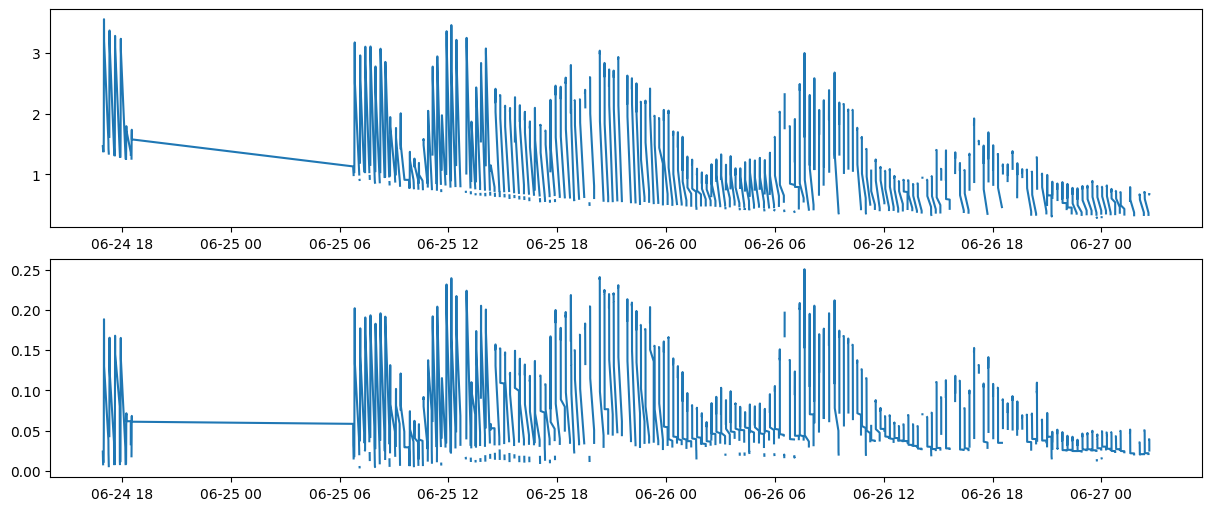

In [26]:
acs2 = acs.sel(wavelength = slice(700, None))

acs2 = acs2.where(acs2.c_mts > 0, drop =True)
acs2 = acs2.where(acs2.c_mts < 10, drop =True)
acs2 = acs2.where(acs2.a_mts > 0, drop =True)
acs2 = acs2.where(acs2.a_mts < 10, drop =True)

acs2 = acs2.rolling(time = 4*60 + 1, center = True).median(skipna = True)


a715 = acs2.sel(wavelength = 715)
a730 = acs2.sel(wavelength = 730)

fig, ax = plt.subplots(2,1,figsize = (12,5), constrained_layout = True)
ax[0].plot(a715.time, a715.c_mts)
ax[1].plot(a715.time, a715.a_mts)


## Remove Poor Quality Data

Because OOI distributes ACS data parsed into its raw values, we can probably assume that the gap and syntax tests passed.

In [ ]:
print(f'Total Number of ACS Spectra Before Removal: {len(acs.time.values)}')

In [ ]:
acs = acs.where(acs.flag_elapsed_time != 4, drop = True)  # Remove samples with a flag of 4 for the elapsed time test
acs = acs.where(acs.flag_internal_temperature != 4, drop = True)  # Remove samples with a flag of 4 for the internal temperature test.
acs = acs.where(acs.flag_a_uncorrected_inf_nan != 4, drop = True)  # Remove samples with a flag of 4 for the absorption inf nan test.
acs = acs.where(acs.flag_c_uncorrected_inf_nan != 4, drop = True)  # Remove samples with a flag of 4 for the absorption inf nan test.

In [ ]:
print(f'Total Number of ACS Spectra After Removal: {len(acs.time.values)}')

## Sidebar: Quick Plot a Spectrum

In [ ]:
spectrum = acs.sel(time = acs.time.values[-10000])

fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharex = True)

ax[0].set_title('Absorption')
ax[0].axhline(0, color = 'k', linestyle = '--')
ax[0].axvline(reference_wavelength, color = 'k', linestyle = '--')
ax[0].plot(spectrum.wavelength, spectrum.a_mts, label='a_mts')
ax[0].plot(spectrum.wavelength, spectrum.a_mts_baseline, label = 'a_mts_baseline')
ax[0].plot(spectrum.wavelength, spectrum.a_mts_baseline_plus, label = 'a_mts_baseline_plus')
ax[0].plot(spectrum.wavelength, spectrum.a_mts_proportional, label = 'a_mts_proportional')
ax[0].plot(spectrum.wavelength, spectrum.a_mts_proportional_plus, label = 'a_mts_proportional_plus')
ax[0].legend(loc = 'upper right', ncols = 1)
ax[0].set_ylim(-.1,1.3)
ax[0].yaxis.set_major_locator(MultipleLocator(0.25))
ax[0].yaxis.set_minor_locator(MultipleLocator(0.05))

ax[1].set_title('Attenuation')
ax[1].plot(spectrum.wavelength, spectrum.c_mts, label = 'c_mts')
ax[1].axvline(reference_wavelength, color = 'k', linestyle = '--')
ax[1].legend(loc = 'upper right', ncols = 1)
ax[1].set_ylim(2.4,3)
ax[1].yaxis.set_major_locator(MultipleLocator(0.25))
ax[1].yaxis.set_minor_locator(MultipleLocator(0.05))

ax[-1].xaxis.set_major_locator(MultipleLocator(50))
ax[-1].xaxis.set_minor_locator(MultipleLocator(5))

ax[0].set_ylabel(r'Absorption ($m^{-1}$)')
ax[1].set_ylabel(r'Attenuation ($m^{-1}$)')
ax[0].set_xlabel('Wavelength (nm)')
ax[1].set_xlabel('Wavelength (nm)')

# Export Data

To export data to a new netCDF, you can use Xarray's builtin to_netcdf function. It is important to define the time encoding so that files are compatible between languages (Python, MATLAB, R, etc.).


<br>

```
from acspype.core import NC_ENCODING
acs.to_netcdf('processed.nc', encoding=ENCODING)
```